# ML Reglas de Precio

Objetivo: Identificar características importantes para asignación de reglas de precio e incremento de Ingresos (Estimated Revenue)

Variables disponibles cualitativas:  
    - Día (Day)CONFIGURABLE  
    - Día de la semana (Weekday)  
    - Sitio (Site) CONFIGURABLE  
    - Tamaño de creativo (Creative Size) CONFIGURABLE  
    - Dispositivo (Device category) CONFIGURABLE  
    - País (Country) CONFIGURABLE  
    - Nombre Regla de Precio (pricing rule name)

Variables disponibles cuantitativas:  
    - Regla de Precio
    - Ad Requests.  
    - Matched Requests.  
    - Clicks.  
    - Estimated Revenue  
    - Ad Impressions  
    - Active View Enabled Impressions  
    - Active View measured Impressions  
    
$$eCPM = \frac{Ingresos}{Impresiones Vendidas} * 1000$$  
$$Fill Rate = \frac{Impresiones Vendidas}{Oportunidades}$$  
$$rCPM = \frac{Ingresos}{Oportunidades} * 1000 = eCPM * Fill Rate$$  
$$Viewability = \frac{Impresiones Vistas}{Impresiones Disponibles} * 1000$$

Target: Maximizar ingresos (revenue)  
Inputs: weekday, site, creative_size, device_category, country.  
Output: Regla de Precio.

In [700]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [701]:
try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20
    
try:
    from sklearn.preprocessing import OrdinalEncoder # just to raise an ImportError if Scikit-Learn < 0.20
    from sklearn.preprocessing import OneHotEncoder
except ImportError:
    from future_encoders import OneHotEncoder # Scikit-Learn < 0.20

In [702]:
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

In [703]:
# Función para carga de archivo
import os
import tarfile
import urllib.request
import pandas as pd

PRULES_PATH = os.path.join("datasets")

def load_prules_data(prules_path=PRULES_PATH,filename="newbase_pricing_rules_open.csv"):
    csv_path = os.path.join(prules_path, filename)
    return pd.read_csv(csv_path)

# Definición de funciones

In [704]:

# Función para asignar a cada instancia el valor promedio

def MeanAsign(row,dfgb,metric,bycat):
    auxlist = []
    for i in bycat:
        auxlist.append(row[bycat])
    auxtuple = tuple(auxlist)
    auxmetric = dfgb.loc[auxtuple][metric]
    return auxmetric

In [651]:
bycat = ['weekday', 'creative_size', 'device', 'country']
prgb = prules.groupby(by=bycat,group_keys=True).mean()
meanbycats = prgb['ad_requests']

prules['aux'] = prules['weekday']+prules['creative_size']+prules['device']+prules['country']
prules['avg_ad_requests'] = 0

for i, v in meanbycats.items():
    prules.loc[prules['aux'] == ''.join(i), 'avg_ad_requests'] = v

prules.head(10)

C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\3118502956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prules['aux'] = prules['weekday']+prules['creative_size']+prules['device']+prules['country']
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\3118502956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prules['avg_ad_requests'] = 0
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\3118502956.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,day,weekday,site,creative_size,device,country,pricing_rules_name,pricing_rules,ad_requests,matched_ad_requests,clicks,revenue,ad_impressions,active_view_enabled_impressions,active_view_measured_impressions,aux,avg_ad_requests
0,28/04/2022,jue,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,16,1,0,0.05,1,1,1,jue300x250DesktopUnited States,1212.714632
1,29/04/2022,vie,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,20,1,0,0.00,0,0,0,vie300x250DesktopUnited States,1143.018993
2,30/04/2022,sáb,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,13,1,0,0.00,0,0,0,sáb300x250DesktopUnited States,653.998219
3,01/05/2022,dom,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,25,2,0,0.12,2,2,2,dom300x250DesktopUnited States,649.324181
4,03/05/2022,mar,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,21,2,0,0.03,2,2,2,mar300x250DesktopUnited States,1286.459592
5,05/05/2022,jue,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,2.0,17,4,0,0.29,3,3,3,jue300x250DesktopUnited States,1212.714632
6,06/05/2022,vie,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,1.8,28,4,0,0.16,4,4,4,vie300x250DesktopUnited States,1143.018993
7,07/05/2022,sáb,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,1.8,18,2,0,0.15,2,2,2,sáb300x250DesktopUnited States,653.998219
8,10/05/2022,mar,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,1.8,9,1,0,0.03,1,1,1,mar300x250DesktopUnited States,1286.459592
9,12/05/2022,jue,Excelsior,300x250,Desktop,United States,1 UPR Desktop USA,1.8,19,1,0,0.00,0,0,0,jue300x250DesktopUnited States,1212.714632


In [721]:

# Clase para añadir atributos combinados al set

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, y=None): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    # def transform(self, X, bycat=['creative_size', 'weekday', 'site', 'device', 'country'], metric='ad_requests', y=None):
    def transform(self, X, y=None):
        X = X[(X['active_view_measured_impressions']>0) & (X['ad_requests']>0)]
        X['rCPM'] = X['revenue']/X['ad_requests']*1000 # Añade rCPM al set
        X['FillRate'] = X['ad_impressions']/X['ad_requests'] # Añade FillRate al Set
        X['eCPM'] = X['revenue']/X['ad_impressions']*1000 # Añade eCPM al set
        #X['Viewability'] = X['active_view_viewed_impressions']/X['active_view_enabled_impressions'] # Añade Viewability al set IGUAL HACERLO EN PROMEDIO.
        
        # Para añadir promedio de Ad Requests
        Xgb = X.groupby(by=['weekday', 'creative_size', 'device', 'country'],group_keys=True).mean()
        meanbycats = Xgb['ad_requests']
        X['aux'] = X['weekday']+X['creative_size']+X['device']+X['country']
        X['avg_ad_requests'] = 0
        X['avg_viewed_impressions'] = 0
        X['avg_enabled_impressions'] = 0
        # Agrega Ad Requests Promedio
        for i, v in meanbycats.items():
            X.loc[X['aux'] == ''.join(i), 'avg_ad_requests'] = v
        
        # Para cálculo de Viewability ponderado
        
        # Agrega Viewed Impressions
        meanbycats = Xgb['active_view_viewed_impressions']    
        for i, v in meanbycats.items():
            X.loc[X['aux'] == ''.join(i), 'avg_viewed_impressions'] = v   
        # Agrega Enabled Impressions
        meanbycats = Xgb['active_view_enabled_impressions']    
        for i, v in meanbycats.items():
            X.loc[X['aux'] == ''.join(i), 'avg_enabled_impressions'] = v    
            
        X['Viewability_pond'] = X['avg_viewed_impressions']/X['avg_enabled_impressions'] # División Viewability pond
        
        # Eliminar campos auxiliares
        X = X.drop(['aux','avg_viewed_impressions','avg_enabled_impressions'], axis=1)
        return X

In [697]:
Xgb = prules.groupby(by=['weekday', 'creative_size', 'device', 'country'],group_keys=True).mean()
Xgb['ad_requests']

weekday  creative_size  device                   country      
dom      300x100        Desktop                  Mexico           42457.585714
                                                 United States     3357.742424
                        High-end mobile devices  Mexico           76194.236025
                                                 United States     4108.426471
         300x250        Desktop                  Mexico           13422.812395
                                                                      ...     
vie      Sin Posicion   High-end mobile devices  United States       87.695935
         Tags           Desktop                  Mexico           14596.119205
                                                 United States      947.848485
                        High-end mobile devices  Mexico           79930.369369
                                                 United States     7603.171717
Name: ad_requests, Length: 232, dtype: float64

In [653]:

# (Estrategia 1) Función para definir si la instancia entrada tiene eCPM superior al eCPM general 

def categorise(row,dfgb,porc):
    cpm_inst = row['eCPM'] # Se obtiene el CPM de la instancia
    c_size = row['creative_size'] # Se obtiene el creative_size de la instancia
    cpm_pond = (dfgb.loc[c_size]['revenue']/dfgb.loc[c_size]['ad_impressions']*1000) # Se obtiene el CPM general del creative size
    
    if cpm_inst > cpm_pond*(1+porc): # Se compara cpm de la instancia vs cpm general del creative size
        return 1
    else:
        return 0 

In [654]:

# Clase para filtrar instancias que cumplan con CPM superior a la media y fill rate

class StrategyCPMSuperior(BaseEstimator, TransformerMixin):
    def __init__(self, porc=0, fill_rate=.60, limit_cpm=150): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, porc=0, fill_rate=.60, limit_cpm=150):
        Xgb = X.groupby('creative_size').sum() # Se crea matriz para cálculo de eCPM general
        X['flag_cpm_sup'] = X.apply(lambda row: categorise(row,Xgb,porc), axis=1) # Se añade columna con flag 0-1 para determinar si cumple con criterio
        X = X[(X['FillRate']>fill_rate) & ((X['flag_cpm_sup']==1) & (X['eCPM']<limit_cpm))] # Se filtran instancias que cumplan con criterios.
        X = X.reset_index(drop = True) # Resetea index para evitar errores posteriormente
        return X

In [655]:
prulesgbcpm = prulescpm.groupby('creative_size').count()
prulesgbcpm['pricing_rules'].head(20)

creative_size
300x100          157
300x250         2559
300x600          692
320x100          306
320x50           226
728x90          2998
Native            11
Sin Posicion    2355
Name: pricing_rules, dtype: int64

In [656]:

# (Estrategia 2) Función para definir si la instancia entrada es real_pricing > floor_pricing

def categorise_pricing(row,porc):
    if row['ad_impressions'] > 0: # Condicional para evitar indeterminación en división de métrica real_pricing
        real_pricing = row['revenue']/row['ad_impressions'] # Se obtiene métrica real_pricing
        floor_pricing = row['pricing_rules']*row['ad_impressions']/1000000 # Se obtiene métrica real_pricing
    else:
        real_pricing = 0
        floor_pricing = 0
    
    if real_pricing > floor_pricing*(1+porc): # Se compara real pricing con floor pricing, con un % mínimo
        return 1
    else:
        return 0 

In [657]:

# Clase para filtrar instancias que cumplan con real_pricing > floor_pricing y fill rate

class StrategyRealvsFloorPricing(BaseEstimator, TransformerMixin):
    def __init__(self, porc=0, fill_rate=.60, limit_cpm=150): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, porc=0, fill_rate=.60, limit_cpm=150):
        X['flag_pricing_sup'] = X.apply(lambda row: categorise_pricing(row,porc), axis=1) # Se añade columna con flag 0-1 para determinar si cumple con criterio
        X = X[(X['FillRate']>fill_rate) & ((X['flag_pricing_sup']==1) & (X['eCPM']<limit_cpm))] # Se filtran instancias que cumplan con criterios.
        X = X.reset_index(drop = True) # Resetea index para evitar errores posteriormente
        return X

In [658]:

# Clase para estratificar por regla de precio y dividir en set de entrenamiento y set de validación

class Strat_sets(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kwargs
        self # nothing else to do
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        #X["pr_cat"] = pd.cut(X["weekday"],
        #                       bins=['jue', 'vie', 'sáb', 'dom', 'mar', 'lun', 'mié'],
        #                       labels=[1, 2, 3, 4, 5])
        split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
        for train_index, test_index in split.split(X, X["weekday"]): # Estratificado de set.
            X_train_set = X.loc[train_index]
            X_test_set = X.loc[test_index]
        return X_train_set, X_test_set

In [659]:
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
# REVISAR SI EXISTE OTRO DATAFRAMESELECTOR NUEVO Y PONERLO ARRIBA PARA USARLO EN ERRORES DE VISUALIZACIÓN DE .HEAD().

In [668]:
num_attribs = ['Viewability', 'avg_ad_requests']
cat_attribs = ['weekday', 'creative_size', 'device', 'country']



old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),# REVISAR DOCUMENTACIÓN DE SIMPLEIMPUTER
        ('std_scaler', StandardScaler()),# DIFERENTES MEDIAS
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [669]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [662]:
from sklearn.preprocessing import PolynomialFeatures

In [663]:
def plot_learning_curves(model, X, y, XTest, yTest): # Entradas sean los sets que ya se aplicó shuffle
    X_train = X
    X_val = XTest
    y_train = y
    y_val = yTest
    train_errors, val_errors = [], []
    #for m in range(1, len(X_train)):
    for m in range(1, 1800):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict)) # 
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    print("Last train error: "+ str(np.sqrt(train_errors[-1])))
    print("Last valid error: "+ str(np.sqrt(val_errors[-1])))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

# Pipelines

### Pipeline estrategia 1

In [722]:
# PARA PRIMERAS PRUEBAS Y ANÁLISIS DE COMPORTAMIENTO, TOMAMOS SOLAMENTE INFORMACIÓN DE EXCÉLSIOR.
# Visualización de la carga
target_site = 'Excelsior'

carga_prules = pd.concat([load_prules_data(filename="pt1_newbase_pricing_rules_open.csv"),load_prules_data(filename="pt2_newbase_pricing_rules_open.csv")])

prules = carga_prules[carga_prules['site'] == target_site]
prulesorg = carga_prules[carga_prules['site'] == target_site]

In [723]:
# Pipeline para limpieza de los datos de estrategia CPM

bycatl = ['creative_size', 'weekday', 'site', 'device', 'country']

clean_cpm_pipeline = clean_realp_pipeline = Pipeline([
        ('attribs_adder', CombinedAttributesAdder()),
        ('strategy_cpm', StrategyCPMSuperior(porc=-.10,fill_rate=.60,limit_cpm=150)),
        ('stratified',Strat_sets()),
])

cpm_train, cpm_test = clean_cpm_pipeline.transform(prulesorg)
# Se asignan etiquetas para set de training
cpm_labels = cpm_train["pricing_rules"].copy()
cpm_train = cpm_train.drop("pricing_rules", axis=1) # drop labels for training set


# Se asignan etiquetas para set de testing
cpm_test_labels = cpm_test["pricing_rules"].copy()
cpm_test = cpm_test.drop("pricing_rules", axis=1)

# GENERAR ETIQUETAS DE TESTING

C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\395035628.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rCPM'] = X['revenue']/X['ad_requests']*1000 # Añade rCPM al set
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\395035628.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FillRate'] = X['ad_impressions']/X['ad_requests'] # Añade FillRate al Set
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\395035628.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [724]:
cpm_train.head(5)

,day,weekday,site,creative_size,device,country,pricing_rules_name,ad_requests,matched_ad_requests,clicks,...,ad_impressions,active_view_enabled_impressions,active_view_measured_impressions,active_view_viewed_impressions,rCPM,FillRate,eCPM,avg_ad_requests,Viewability_pond,flag_cpm_sup
5177,21/09/2021,mar,Excelsior,728x90,Desktop,United States,DEFAULT USA - UPR,1,1,0,...,1,1,1,0,10.000000,1.000000,10.000000,733.053299,0.806088,1
4912,25/08/2021,mié,Excelsior,728x90,Desktop,United States,DEFAULT USA - UPR,22,17,0,...,16,16,16,7,10.909091,0.727273,15.000000,771.770607,0.807997,1
7815,12/12/2021,dom,Excelsior,728x90,High-end mobile devices,United States,DEFAULT USA - UPR,103,63,0,...,63,63,63,58,16.601942,0.611650,27.142857,520.757724,0.726620,1
7145,25/11/2021,jue,Excelsior,728x90,Desktop,United States,DEFAULT USA - UPR,43,32,0,...,32,32,32,32,12.558140,0.744186,16.875000,752.870290,0.792696,1
4479,21/07/2021,mié,Excelsior,Sin Posicion,Desktop,United States,DEFAULT USA - UPR,3,2,0,...,2,2,2,0,20.000000,0.666667,30.000000,38.688312,0.669678,1


In [671]:
cpm_prepared = full_pipeline.fit_transform(cpm_train)
cpmTest_prepared = full_pipeline.fit_transform(cpm_test)

Last train error: 1.3253240689566053
Last valid error: 1.278413613963239


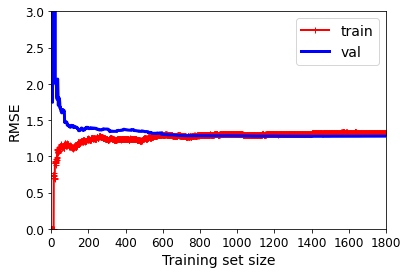

In [672]:

# Curvas de aprendizaje de modelo lineal

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(lin_reg, cpm_prepared, cpm_labels, cpmTest_prepared, cpm_test_labels)
plt.axis([0, 1800, 0, 3])                         # not shown in the book
plt.show()

In [634]:
# Con set completo baja a 

from sklearn.metrics import mean_squared_error

cpm_predictions = lin_reg.predict(cpm_prepared)
lin_mse = mean_squared_error(cpm_labels, cpm_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.302747825420241

Last train error: 0.9365134626440739
Last valid error: 2.1137711951890723


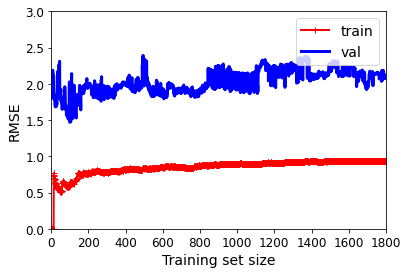

In [674]:

# Curvas de aprendizaje de modelo Arbol de Decisión

## Arbol de decisiones
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(tree_reg, cpm_prepared, cpm_labels, cpmTest_prepared, cpm_test_labels)
plt.axis([0, 1800, 0, 3])                         # not shown in the book
plt.show()

Last train error: 1.3654699949750086
Last valid error: 1.303558207051595


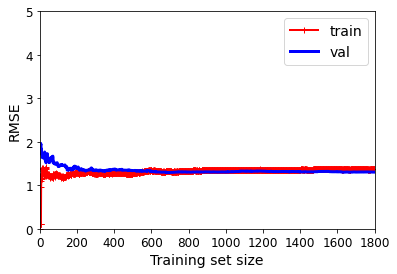

In [675]:
# Curvas de aprendizaje de modelo SVM

## SVM
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
#svm_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(svm_reg, cpm_prepared, cpm_labels, cpmTest_prepared, cpm_test_labels)
plt.axis([0, 1800, 0, 5])                         # not shown in the book
plt.show()

Last train error: 1.2103784392479744
Last valid error: 404410971753.87787


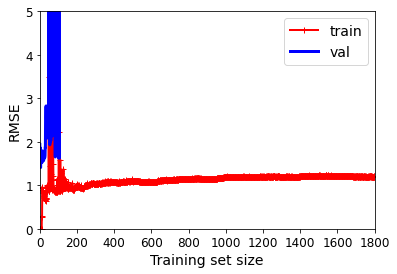

In [470]:

# Curvas de aprendizaje de polinomial grado 2

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, cpm_prepared, cpm_labels, cpmTest_prepared, cpm_test_labels)
plt.axis([0, 1800, 0, 5])                         # not shown in the book
plt.show()

In [448]:

# Curvas de aprendizaje de grid_search

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)

plot_learning_curves(grid_search, cpm_prepared, cpm_labels, cpmTest_prepared, cpm_test_labels)
plt.axis([0, 1800, 0, 5])                         # not shown in the book
plt.show()

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=1.

### Pipeline Estrategia 2

In [676]:
clean_realp_pipeline = Pipeline([
        ('attribs_adder', CombinedAttributesAdder()),
        ('strategy_realp', StrategyRealvsFloorPricing(porc=.10,fill_rate=.60,limit_cpm=150)),
        ('stratified',Strat_sets()),
])

realp_train, realp_test = clean_realp_pipeline.transform(prulesorg)
# Se asignan etiquetas para set de training
realp = realp_train.drop("pricing_rules", axis=1) # drop labels for training set
realp_labels = realp_train["pricing_rules"].copy()

# Se asignan etiquetas para set de testing
realp_test_labels = realp_test["pricing_rules"].copy()
realp_test = realp_test.drop("pricing_rules", axis=1)

# GENERAR ETIQUETAS DE TESTING

C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\3297767915.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['rCPM'] = X['revenue']/X['ad_requests']*1000 # Añade rCPM al set
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\3297767915.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['FillRate'] = X['ad_impressions']/X['ad_requests'] # Añade FillRate al Set
C:\Users\Aaron\AppData\Local\Temp\ipykernel_14288\3297767915.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [677]:
realp_prepared = full_pipeline.fit_transform(realp)
realpTest_prepared = full_pipeline.fit_transform(realp_test)

Last train error: 1.3054176724636761
Last valid error: 1.3222598817221436


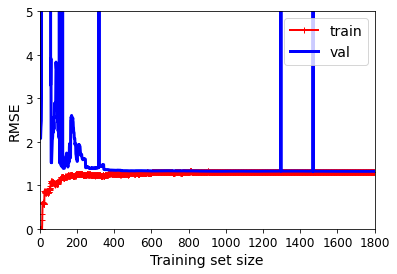

In [678]:

# Curvas de aprendizaje de modelo lineal

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
#lin_reg.fit(realp_prepared, realpTest_labels)

plot_learning_curves(lin_reg, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 1800, 0, 5])                         # not shown in the book
plt.show()

Last train error: 0.9778093162370745
Last valid error: 1.730979912573222


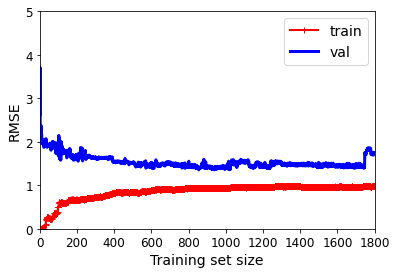

In [679]:

# Curvas de aprendizaje de modelo Arbol de Decisión

## Arbol de decisiones
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
#tree_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(tree_reg, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 1800, 0, 5])                         # not shown in the book
plt.show()

Last train error: 1.3898797776613998
Last valid error: 1.3905728296208772


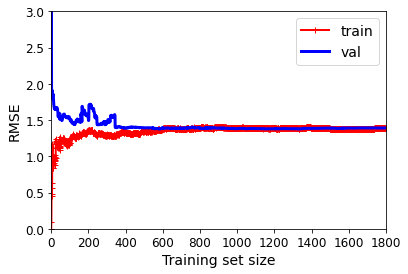

In [680]:
# Curvas de aprendizaje de modelo SVM

## SVM
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
#svm_reg.fit(cpm_prepared, cpm_labels)

plot_learning_curves(svm_reg, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 1800, 0, 3])                         # not shown in the book
plt.show()

Last train error: 1.1678465802630253
Last valid error: 958542875.726994


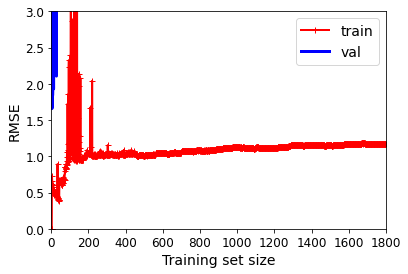

In [607]:

# Curvas de aprendizaje de polinomial grado 2

from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, realp_prepared, realp_labels, realpTest_prepared, realp_test_labels)
plt.axis([0, 1800, 0, 3])                         # not shown in the book
plt.show()